In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from cnn_modelling.model import MRINet
from cnn_modelling.utils import RMSELoss, SaveBestModelMetrics
from dataset import IXIDataset
from sklearn.metrics import (accuracy_score, balanced_accuracy_score,
                             mean_absolute_error, mean_squared_error, r2_score)
from sklearn.model_selection import train_test_split
from tqdm import tqdm

### Configuration

In [2]:
PREPROCESSED_SCANS_DIRECTORY = r"/home/dpolak/Downloads/IXI_output/"
IXI_DEMOGRAPHIC_DATA = r"/home/dpolak/Downloads/IXI.xls"
num_epochs = 50
batch_size = 4

### Loading and splitting the data into train, test and validation

In [3]:
df_main = pd.read_excel(IXI_DEMOGRAPHIC_DATA)
df_main.dropna(inplace=True, subset=("IXI_ID", "SEX_ID (1=m, 2=f)", "AGE"))

In [4]:
train_df, valid_df = train_test_split(df_main, test_size=0.2, random_state=2137, stratify=df_main["SEX_ID (1=m, 2=f)"])
valid_df, test_df = train_test_split(valid_df, test_size=0.5, random_state=2137)

In [5]:
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [6]:
train_dataloader = torch.utils.data.DataLoader(IXIDataset(train_df, PREPROCESSED_SCANS_DIRECTORY, augment=True), batch_size=batch_size, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(IXIDataset(valid_df, PREPROCESSED_SCANS_DIRECTORY), batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(IXIDataset(test_df, PREPROCESSED_SCANS_DIRECTORY), batch_size=batch_size, shuffle=True)

Loaded 470 samples.
Loaded 59 samples.
Loaded 59 samples.


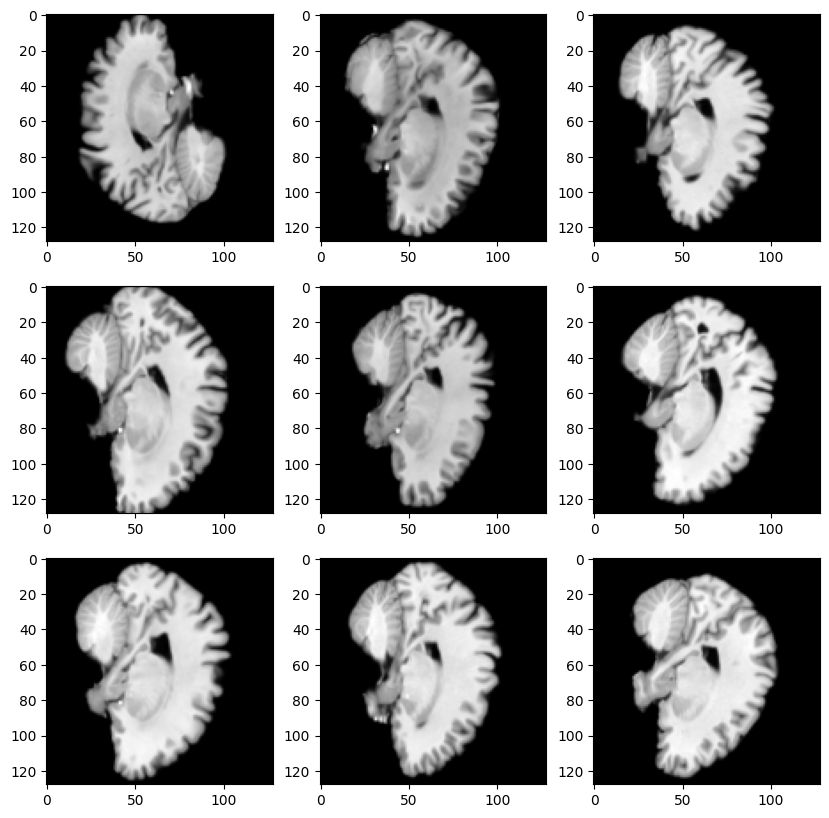

In [7]:
plt.figure(figsize=(10,10))
for i, (image, (_, __)) in enumerate(valid_dataloader):
    image = image.cpu().numpy()
    plt.subplot(3, 3, i + 1)
    plt.imshow(image[0, 0, 50, :, :], cmap="gray")
    if i == 8:
        break

## Training the model

In [8]:
model = MRINet()
model = model.to("cuda")

In [9]:
class_weights = (df_main["SEX_ID (1=m, 2=f)"].value_counts().to_numpy() / len(df_main)) ** -1
print(class_weights)

[1.79878049 2.2519084 ]


In [10]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion_ce = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights))
criterion_mse = RMSELoss()
save_best = SaveBestModelMetrics(save_path="models/pretrained")
history = {"train_loss": [], "val_loss": []}

for epoch in range(num_epochs):
    train_mse, train_ce, val_ce, val_mse, running_loss, val_running_loss = 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
    prbar = tqdm(train_dataloader, leave=True)
    model.train()
    step = 1
    results_sex, ground_truths_sex = [], []
    results_age, ground_truths_age = [], []
    for batch in prbar:
        inputs, (gt_age, gt_sex) = batch
        optimizer.zero_grad()
        output_age, output_sex = model(inputs)
        mse = criterion_mse(output_age.squeeze().to("cpu"), gt_age)
        ce = criterion_ce(output_sex.squeeze().to("cpu"), gt_sex) * 5
        loss = mse + ce
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        train_mse += mse.item()
        train_ce += ce.item()
        
        probabilities = torch.argmax(torch.softmax(output_sex, dim=1), dim=1)
        results_sex.extend(probabilities.to("cpu").detach().flatten().numpy())
        ground_truths_sex.extend(torch.argmax(gt_sex, dim=1))
        
        results_age.extend(output_age.squeeze().to("cpu").detach().numpy())
        ground_truths_age.extend(gt_age.squeeze().to("cpu").detach().numpy())
        
        accuracy = accuracy_score(ground_truths_sex, results_sex)
        balanced_accuracy = balanced_accuracy_score(ground_truths_sex, results_sex, adjusted=False)
        r2 = r2_score(ground_truths_age, results_age)
        
        prbar.set_description(
            f"Epoch: {epoch}, "
            f"Step loss: {round(loss.item(), 3)}, "
            f"Train CE: {round(train_ce / step, 3)}, "
            f"Train MSE: {round(train_mse / step, 3)}, "
            f"Train Accuracy: {round(accuracy, 3)}, "
            f"Train Balanced Accuracy: {round(balanced_accuracy, 3)},"
            f"Train R2: {round(r2, 3)},"
            f"Running Loss: {round(running_loss / step, 3)}"
        )
        step += 1
        history["train_loss"].append(running_loss / step)
    model.eval()

    with torch.no_grad():
        step = 1
        results_sex, ground_truths_sex = [], []
        results_age, ground_truths_age = [], []
        prbar = tqdm(valid_dataloader, leave=True)
        for batch in prbar:
            inputs, (gt_age, gt_sex) = batch
            output_age, output_sex = model(inputs)
            mse = criterion_mse(output_age.squeeze().to("cpu"), gt_age) 
            ce = criterion_ce(torch.sigmoid(output_sex).squeeze().to("cpu"), gt_sex) * 5
            probabilities = torch.argmax(torch.softmax(output_sex, dim=1), dim=1)
            
            results_sex.extend(probabilities.to("cpu").detach().flatten().numpy())
            ground_truths_sex.extend(torch.argmax(gt_sex, dim=1))
            
            results_age.extend(output_age.squeeze().to("cpu").detach().numpy())
            ground_truths_age.extend(gt_age.squeeze().to("cpu").detach().numpy())
            
            accuracy = accuracy_score(ground_truths_sex, results_sex)
            balanced_accuracy = balanced_accuracy_score(ground_truths_sex, results_sex, adjusted=False)
            r2 = r2_score(ground_truths_age, results_age)
            
            val_mse += mse.item()
            val_ce += ce.item()
            loss = ce + mse
            val_running_loss += loss.item()
            
            prbar.set_description(
                f"Validation epoch: {epoch}, Step loss: {round(loss.item(), 3)}, "
                f"Valid CE: {round(val_ce / step, 3)}, "
                f"Valid MSE: {round(val_mse / step, 3)}, "
                f"Valid Accuracy: {round(accuracy, 3)}, "
                f"Valid Balanced Accuracy: {round(balanced_accuracy, 3)},"
                f"Valid R2: {round(r2, 3)},"
                f"Running Loss: {round(val_running_loss / step, 3)}"
            )
            
            step += 1
        history["val_loss"].append(val_running_loss / step)
    save_best(balanced_accuracy + r2, epoch, model)

Epoch: 0, Step loss: 55.085, Train CE: 9.185, Train MSE: 43.982, Train Accuracy: 0.543, Train Balanced Accuracy: 0.524,Train R2: -6.357,Running Loss: 53.167: 100%|██████████| 118/118 [00:47<00:00,  2.47it/s]
Validation epoch: 0, Step loss: 35.291, Valid CE: 7.089, Valid MSE: 39.742, Valid Accuracy: 0.525, Valid Balanced Accuracy: 0.534,Valid R2: -5.127,Running Loss: 46.831: 100%|██████████| 15/15 [00:03<00:00,  3.98it/s]



Best validation metric: -4.593178277377646

Saving best model for epoch: 1


Epoch: 1, Step loss: 21.341, Train CE: 8.757, Train MSE: 27.597, Train Accuracy: 0.57, Train Balanced Accuracy: 0.556,Train R2: -2.113,Running Loss: 36.355: 100%|██████████| 118/118 [00:47<00:00,  2.49it/s] 
Validation epoch: 1, Step loss: 34.813, Valid CE: 6.786, Valid MSE: 22.811, Valid Accuracy: 0.542, Valid Balanced Accuracy: 0.5,Valid R2: -1.075,Running Loss: 29.597: 100%|██████████| 15/15 [00:03<00:00,  3.99it/s]



Best validation metric: -0.5745587627587825

Saving best model for epoch: 2


Epoch: 2, Step loss: 17.589, Train CE: 8.887, Train MSE: 15.691, Train Accuracy: 0.557, Train Balanced Accuracy: 0.539,Train R2: 0.015,Running Loss: 24.578: 100%|██████████| 118/118 [00:48<00:00,  2.43it/s] 
  0%|          | 0/15 [00:00<?, ?it/s]/home/dpolak/miniconda3/envs/CV/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
Validation epoch: 2, Step loss: 19.674, Valid CE: 7.141, Valid MSE: 13.453, Valid Accuracy: 0.525, Valid Balanced Accuracy: 0.554,Valid R2: 0.288,Running Loss: 20.595: 100%|██████████| 15/15 [00:02<00:00,  5.19it/s]



Best validation metric: 0.841601312697933

Saving best model for epoch: 3


Epoch: 3, Step loss: 12.149, Train CE: 8.04, Train MSE: 14.855, Train Accuracy: 0.589, Train Balanced Accuracy: 0.573,Train R2: 0.13,Running Loss: 22.896: 100%|██████████| 118/118 [00:44<00:00,  2.65it/s]  
  0%|          | 0/15 [00:00<?, ?it/s]/home/dpolak/miniconda3/envs/CV/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
Validation epoch: 3, Step loss: 22.363, Valid CE: 6.663, Valid MSE: 14.849, Valid Accuracy: 0.559, Valid Balanced Accuracy: 0.519,Valid R2: 0.131,Running Loss: 21.512: 100%|██████████| 15/15 [00:02<00:00,  5.17it/s]
Epoch: 4, Step loss: 36.679, Train CE: 8.57, Train MSE: 15.058, Train Accuracy: 0.553, Train Balanced Accuracy: 0.538,Train R2: 0.102,Running Loss: 23.628: 100%|██████████| 118/118 [00:41<00:00,  2.84it/s] 
  0%|          | 0/15 [00:00<?, ?it/s]/home/dpolak/miniconda3/envs/CV/lib/python3.10/site-packages/sklearn/metrics/_classi


Best validation metric: 0.8713970770158821

Saving best model for epoch: 7


Epoch: 7, Step loss: 18.461, Train CE: 8.39, Train MSE: 14.248, Train Accuracy: 0.538, Train Balanced Accuracy: 0.518,Train R2: 0.208,Running Loss: 22.638: 100%|██████████| 118/118 [00:42<00:00,  2.80it/s] 
Validation epoch: 7, Step loss: 10.266, Valid CE: 6.591, Valid MSE: 13.044, Valid Accuracy: 0.593, Valid Balanced Accuracy: 0.556,Valid R2: 0.279,Running Loss: 19.635: 100%|██████████| 15/15 [00:02<00:00,  5.21it/s]
Epoch: 8, Step loss: 16.521, Train CE: 7.992, Train MSE: 13.821, Train Accuracy: 0.57, Train Balanced Accuracy: 0.55,Train R2: 0.246,Running Loss: 21.813: 100%|██████████| 118/118 [00:41<00:00,  2.81it/s]  
Validation epoch: 8, Step loss: 14.946, Valid CE: 6.628, Valid MSE: 11.821, Valid Accuracy: 0.559, Valid Balanced Accuracy: 0.519,Valid R2: 0.402,Running Loss: 18.449: 100%|██████████| 15/15 [00:02<00:00,  5.11it/s]



Best validation metric: 0.9205784042299251

Saving best model for epoch: 9


Epoch: 9, Step loss: 22.133, Train CE: 7.536, Train MSE: 13.644, Train Accuracy: 0.619, Train Balanced Accuracy: 0.603,Train R2: 0.268,Running Loss: 21.18: 100%|██████████| 118/118 [00:42<00:00,  2.77it/s] 
Validation epoch: 9, Step loss: 24.846, Valid CE: 6.86, Valid MSE: 11.266, Valid Accuracy: 0.559, Valid Balanced Accuracy: 0.545,Valid R2: 0.455,Running Loss: 18.125: 100%|██████████| 15/15 [00:02<00:00,  5.24it/s] 



Best validation metric: 0.9993037354035686

Saving best model for epoch: 10


Epoch: 10, Step loss: 24.928, Train CE: 8.158, Train MSE: 13.185, Train Accuracy: 0.557, Train Balanced Accuracy: 0.534,Train R2: 0.284,Running Loss: 21.343: 100%|██████████| 118/118 [00:42<00:00,  2.78it/s]
Validation epoch: 10, Step loss: 16.793, Valid CE: 6.841, Valid MSE: 11.901, Valid Accuracy: 0.695, Valid Balanced Accuracy: 0.707,Valid R2: 0.398,Running Loss: 18.742: 100%|██████████| 15/15 [00:02<00:00,  5.23it/s]



Best validation metric: 1.1052753378896814

Saving best model for epoch: 11


Epoch: 11, Step loss: 20.418, Train CE: 7.418, Train MSE: 13.235, Train Accuracy: 0.579, Train Balanced Accuracy: 0.559,Train R2: 0.307,Running Loss: 20.653: 100%|██████████| 118/118 [00:41<00:00,  2.83it/s]
Validation epoch: 11, Step loss: 13.201, Valid CE: 6.662, Valid MSE: 12.097, Valid Accuracy: 0.678, Valid Balanced Accuracy: 0.657,Valid R2: 0.384,Running Loss: 18.76: 100%|██████████| 15/15 [00:02<00:00,  5.22it/s] 
Epoch: 12, Step loss: 9.668, Train CE: 7.101, Train MSE: 12.992, Train Accuracy: 0.591, Train Balanced Accuracy: 0.572,Train R2: 0.305,Running Loss: 20.093: 100%|██████████| 118/118 [00:42<00:00,  2.80it/s] 
Validation epoch: 12, Step loss: 14.867, Valid CE: 6.703, Valid MSE: 14.016, Valid Accuracy: 0.593, Valid Balanced Accuracy: 0.556,Valid R2: 0.177,Running Loss: 20.719: 100%|██████████| 15/15 [00:02<00:00,  5.20it/s]
Epoch: 13, Step loss: 13.651, Train CE: 7.47, Train MSE: 13.642, Train Accuracy: 0.6, Train Balanced Accuracy: 0.583,Train R2: 0.249,Running Loss: 21.


Best validation metric: 1.1053728466261452

Saving best model for epoch: 16


Epoch: 16, Step loss: 17.637, Train CE: 7.354, Train MSE: 12.559, Train Accuracy: 0.611, Train Balanced Accuracy: 0.589,Train R2: 0.358,Running Loss: 19.912: 100%|██████████| 118/118 [00:42<00:00,  2.79it/s]
Validation epoch: 16, Step loss: 12.808, Valid CE: 6.547, Valid MSE: 12.865, Valid Accuracy: 0.661, Valid Balanced Accuracy: 0.641,Valid R2: 0.333,Running Loss: 19.412: 100%|██████████| 15/15 [00:02<00:00,  5.24it/s]
  0%|          | 0/118 [00:00<?, ?it/s]/home/dpolak/miniconda3/envs/CV/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
Epoch: 17, Step loss: 25.996, Train CE: 6.664, Train MSE: 12.458, Train Accuracy: 0.623, Train Balanced Accuracy: 0.609,Train R2: 0.376,Running Loss: 19.121: 100%|██████████| 118/118 [00:42<00:00,  2.80it/s]
Validation epoch: 17, Step loss: 33.23, Valid CE: 6.639, Valid MSE: 13.265, Valid Accuracy: 0.763, Valid Balanced Accu


Best validation metric: 1.1933811208931733

Saving best model for epoch: 19


  0%|          | 0/118 [00:00<?, ?it/s]/home/dpolak/miniconda3/envs/CV/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
Epoch: 19, Step loss: 13.868, Train CE: 7.284, Train MSE: 12.618, Train Accuracy: 0.564, Train Balanced Accuracy: 0.545,Train R2: 0.344,Running Loss: 19.901: 100%|██████████| 118/118 [00:41<00:00,  2.82it/s]
Validation epoch: 19, Step loss: 16.725, Valid CE: 6.608, Valid MSE: 10.264, Valid Accuracy: 0.593, Valid Balanced Accuracy: 0.556,Valid R2: 0.555,Running Loss: 16.873: 100%|██████████| 15/15 [00:02<00:00,  5.20it/s]
Epoch: 20, Step loss: 25.051, Train CE: 7.001, Train MSE: 11.966, Train Accuracy: 0.609, Train Balanced Accuracy: 0.587,Train R2: 0.419,Running Loss: 18.968: 100%|██████████| 118/118 [00:42<00:00,  2.79it/s]
Validation epoch: 20, Step loss: 15.368, Valid CE: 6.682, Valid MSE: 10.76, Valid Accuracy: 0.661, Valid Balanced Accu


Best validation metric: 1.3439707833074994

Saving best model for epoch: 24


Epoch: 24, Step loss: 14.4, Train CE: 6.395, Train MSE: 12.55, Train Accuracy: 0.64, Train Balanced Accuracy: 0.621,Train R2: 0.359,Running Loss: 18.945: 100%|██████████| 118/118 [00:42<00:00,  2.79it/s]    
Validation epoch: 24, Step loss: 24.655, Valid CE: 6.551, Valid MSE: 12.836, Valid Accuracy: 0.763, Valid Balanced Accuracy: 0.752,Valid R2: 0.342,Running Loss: 19.387: 100%|██████████| 15/15 [00:02<00:00,  5.15it/s]
Epoch: 25, Step loss: 7.289, Train CE: 7.386, Train MSE: 11.935, Train Accuracy: 0.583, Train Balanced Accuracy: 0.561,Train R2: 0.422,Running Loss: 19.32: 100%|██████████| 118/118 [00:42<00:00,  2.78it/s]  
Validation epoch: 25, Step loss: 7.479, Valid CE: 6.596, Valid MSE: 10.755, Valid Accuracy: 0.695, Valid Balanced Accuracy: 0.67,Valid R2: 0.493,Running Loss: 17.351: 100%|██████████| 15/15 [00:02<00:00,  5.23it/s]  
Epoch: 26, Step loss: 11.114, Train CE: 6.823, Train MSE: 11.757, Train Accuracy: 0.613, Train Balanced Accuracy: 0.594,Train R2: 0.438,Running Loss: 


Best validation metric: 1.3638767795677176

Saving best model for epoch: 32


Epoch: 32, Step loss: 15.181, Train CE: 6.178, Train MSE: 11.887, Train Accuracy: 0.666, Train Balanced Accuracy: 0.647,Train R2: 0.425,Running Loss: 18.065: 100%|██████████| 118/118 [00:41<00:00,  2.82it/s]
  0%|          | 0/15 [00:00<?, ?it/s]/home/dpolak/miniconda3/envs/CV/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
Validation epoch: 32, Step loss: 20.733, Valid CE: 6.519, Valid MSE: 15.457, Valid Accuracy: 0.729, Valid Balanced Accuracy: 0.727,Valid R2: 0.018,Running Loss: 21.977: 100%|██████████| 15/15 [00:02<00:00,  5.16it/s] 
Epoch: 33, Step loss: 25.949, Train CE: 6.543, Train MSE: 11.988, Train Accuracy: 0.632, Train Balanced Accuracy: 0.613,Train R2: 0.413,Running Loss: 18.531: 100%|██████████| 118/118 [00:42<00:00,  2.75it/s]
Validation epoch: 33, Step loss: 22.405, Valid CE: 6.349, Valid MSE: 10.931, Valid Accuracy: 0.695, Valid Balanced Acc


Best validation metric: 1.4776908090985907

Saving best model for epoch: 49


Epoch: 49, Step loss: 19.127, Train CE: 5.775, Train MSE: 11.085, Train Accuracy: 0.717, Train Balanced Accuracy: 0.703,Train R2: 0.498,Running Loss: 16.86: 100%|██████████| 118/118 [00:43<00:00,  2.72it/s] 
Validation epoch: 49, Step loss: 14.177, Valid CE: 6.384, Valid MSE: 8.878, Valid Accuracy: 0.712, Valid Balanced Accuracy: 0.714,Valid R2: 0.685,Running Loss: 15.262: 100%|██████████| 15/15 [00:03<00:00,  4.90it/s]


### Evaluation on the test set

In [11]:
model.load_state_dict(torch.load(f"/home/dpolak/dsc-2023-mri-classification/cnn_modelling/models/pretrained/best_model.pth"))
model.eval()
test_results_age = []
test_ground_truths_age = []
test_results_sex = []
test_ground_truths_sex = []
for test_batch in test_dataloader:
    output_age, output_sex = model.forward(test_batch[0])
    test_results_age.extend(output_age.squeeze().to("cpu").detach().numpy())
    test_ground_truths_age.extend(test_batch[1][0].squeeze().to("cpu").detach().numpy())
    test_results_sex.extend(torch.argmax(torch.softmax(output_sex, dim=1), dim=1).to("cpu").detach().numpy())
    test_ground_truths_sex.extend(torch.argmax(test_batch[1][1], dim=1))
    
test_accuracy = accuracy_score(test_ground_truths_sex, test_results_sex, normalize=True)
test_balanced_accuracy = balanced_accuracy_score(test_ground_truths_sex, test_results_sex,  adjusted=False)
test_mse = mean_squared_error(test_ground_truths_age, test_results_age)
test_mae = mean_absolute_error(test_ground_truths_age, test_results_age)
test_r2 = r2_score(test_ground_truths_age, test_results_age)
print(f"Test Accuracy: {round(test_accuracy, 3)}")
print(f"Test Balanced Accuracy: {round(test_balanced_accuracy, 3)}")
print(f"Test MSE: {round(test_mse, 3)}")
print(f"Test MAE: {round(test_mae, 3)}")
print(f"Test R2: {round(test_r2, 3)}")

Test Accuracy: 0.746
Test Balanced Accuracy: 0.732
Test MSE: 74.55799865722656
Test MAE: 7.3429999351501465
Test R2: 0.758


In [12]:
np.concatenate((np.array(test_results_age).reshape(-1, 1), np.array(test_ground_truths_age).reshape(-1, 1)), axis=1)

array([[90.320496, 75.827515],
       [58.497417, 47.723476],
       [43.46706 , 54.19302 ],
       [80.52034 , 78.20397 ],
       [44.347286, 55.827515],
       [50.67626 , 57.06776 ],
       [39.353767, 52.533882],
       [44.847324, 41.059547],
       [32.604298, 28.24367 ],
       [34.795025, 22.570843],
       [37.02393 , 34.01232 ],
       [34.826946, 24.895277],
       [58.66158 , 65.09514 ],
       [83.392075, 68.481865],
       [54.464638, 70.14374 ],
       [69.009796, 63.540043],
       [42.29639 , 38.234085],
       [47.869164, 56.963722],
       [71.86726 , 72.1451  ],
       [78.700874, 63.41684 ],
       [35.644848, 24.284737],
       [66.500824, 72.13142 ],
       [62.15268 , 58.28063 ],
       [32.978886, 25.938398],
       [34.316082, 27.014374],
       [80.89525 , 72.09035 ],
       [55.99909 , 54.685833],
       [37.08263 , 31.59206 ],
       [34.80549 , 20.16701 ],
       [40.125053, 33.831623],
       [81.545044, 71.206024],
       [37.732525, 30.143738],
       [

In [13]:
np.concatenate((np.array(test_results_sex).reshape(-1,1), np.array(test_ground_truths_sex).reshape(-1,1)), axis=1)

array([[1, 1],
       [0, 0],
       [1, 1],
       [1, 1],
       [1, 0],
       [1, 0],
       [1, 1],
       [1, 1],
       [0, 0],
       [1, 1],
       [1, 1],
       [1, 1],
       [0, 0],
       [0, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [0, 0],
       [1, 1],
       [0, 0],
       [1, 0],
       [1, 0],
       [1, 1],
       [0, 0],
       [1, 1],
       [1, 1],
       [1, 0],
       [1, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 0],
       [1, 0],
       [0, 0],
       [1, 1],
       [1, 1],
       [0, 0],
       [0, 0],
       [1, 1],
       [0, 0],
       [1, 0],
       [0, 0],
       [1, 1],
       [1, 1],
       [0, 1],
       [0, 1],
       [0, 0],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [0, 0],
       [1, 1],
       [0, 1],
       [0, 0],
       [0, 1],
       [0, 0]])